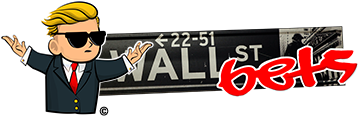


# Visual features

### Fetch images

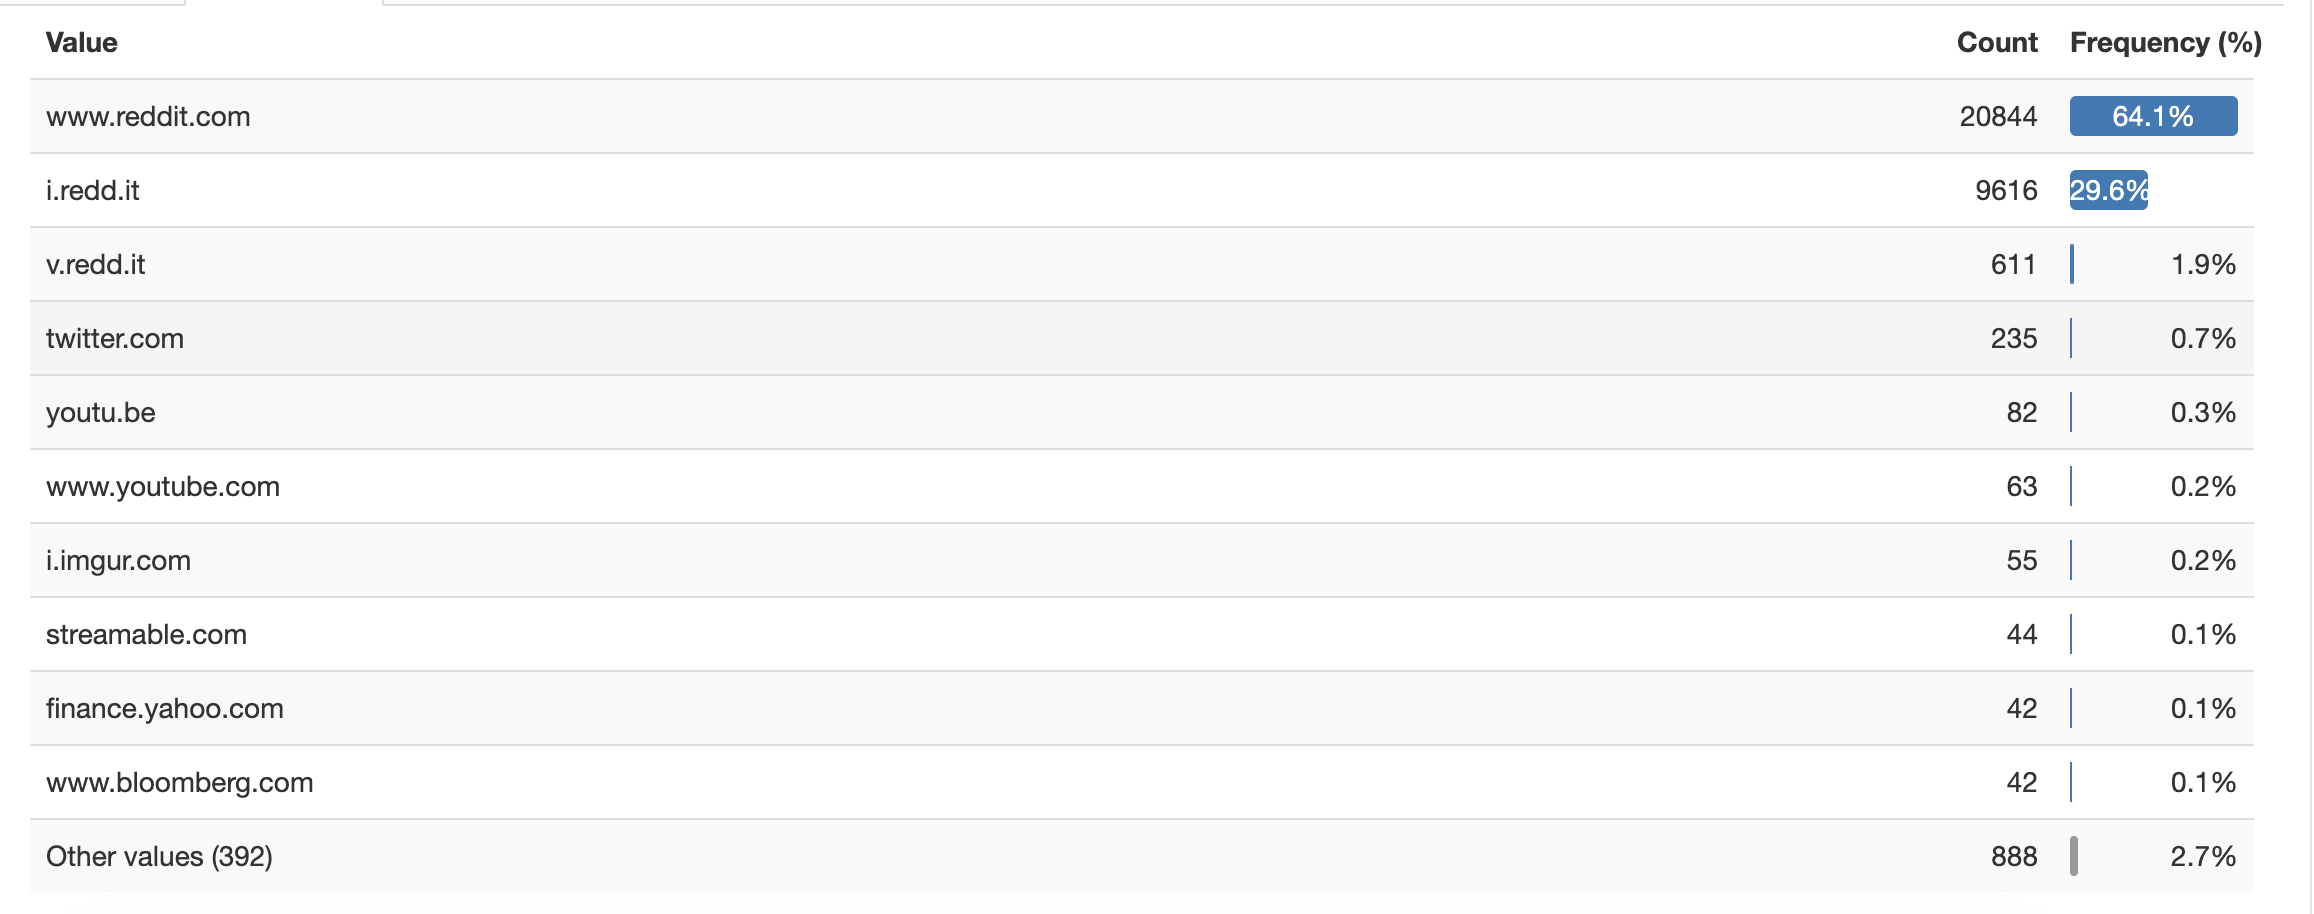

In [ ]:
output_path = "images/"

if not os.path.exists(output_path):
    os.makedirs(output_path)

files = glob.glob(f"{output_path}*.jpg")

df = pd.read_csv('with_post_type.csv', na_filter=False)

def download_image(row):
    id = row['id']
    url = row['url']
    file_path = f"{output_path}{id}.jpg"

    if file_path not in files:
      try:
        urllib.request.urlretrieve(url, file_path)
      except Exception as e:
        print("Oops...", url, e)
        file_path = ''

    if not url.endswith(".jpg") and file_path != '':
      #convert to jpg
      Image.open(file_path).convert('RGB').save(file_path)

    return file_path

df['file_path'] = df.loc[df['type'] == 'image'].apply(download_image, axis='columns')

df.to_csv('with_images.csv', index=False) 

df.head(3)

In [ ]:
df = pd.read_csv('with_images.csv', na_filter=False)

df['type'] = df.apply(lambda x : "deleted_image" if (x['type'] == 'image' and x['file_path'] == '') else x['type'], axis='columns')

df.to_csv('with_image_deleted.csv', index=False) 

df.loc[(df['type'] == 'deleted_image')].head(5)

score      id  ...           type  file_path
86       2  l69ldi  ...  deleted_image           
95      37  lb725x  ...  deleted_image           
198     73  lb4tbp  ...  deleted_image           
260    252  l5cmuu  ...  deleted_image           
271     14  l69ggx  ...  deleted_image           

[5 rows x 93 columns]

In [ ]:
number_of_missing_images = len(df.loc[df['type'] == 'deleted_image'])
number_of_images = len(df.loc[df['type'] == 'image'])

print(number_of_missing_images/number_of_images, number_of_missing_images, number_of_images)

0.024169741697416973 262 10840


### Read text

In [ ]:
batch_size = 10

pipeline = keras_ocr.pipeline.Pipeline(max_size=1000)

df = pd.read_csv('images_text.csv', na_filter=False)

files = glob.glob(f"images/*.jpg")

files = [x for x in files if x not in df.filename.values]

print(df.shape)

batches = np.array_split(files, np.ceil(len(files)/batch_size))

for index, batch in enumerate(batches, start=1):
  start = time.time()

  images = [keras_ocr.tools.read(path) for path in batch]

  prediction_groups = pipeline.recognize(images)

  for filename, group in zip(batch, prediction_groups): 
      words = [x[0] for x in group]
      text = ' '.join(words)

      df = df.append({"filename": filename, "image_text": text}, sort=False, ignore_index=True)
  
  elapsed = time.time() - start

  print(f"Processed: {index*batch_size} images, Batch processing time: {elapsed} s")

  df.to_csv('images_text.csv', index=False) 

df.head(10)

### Example of text read 

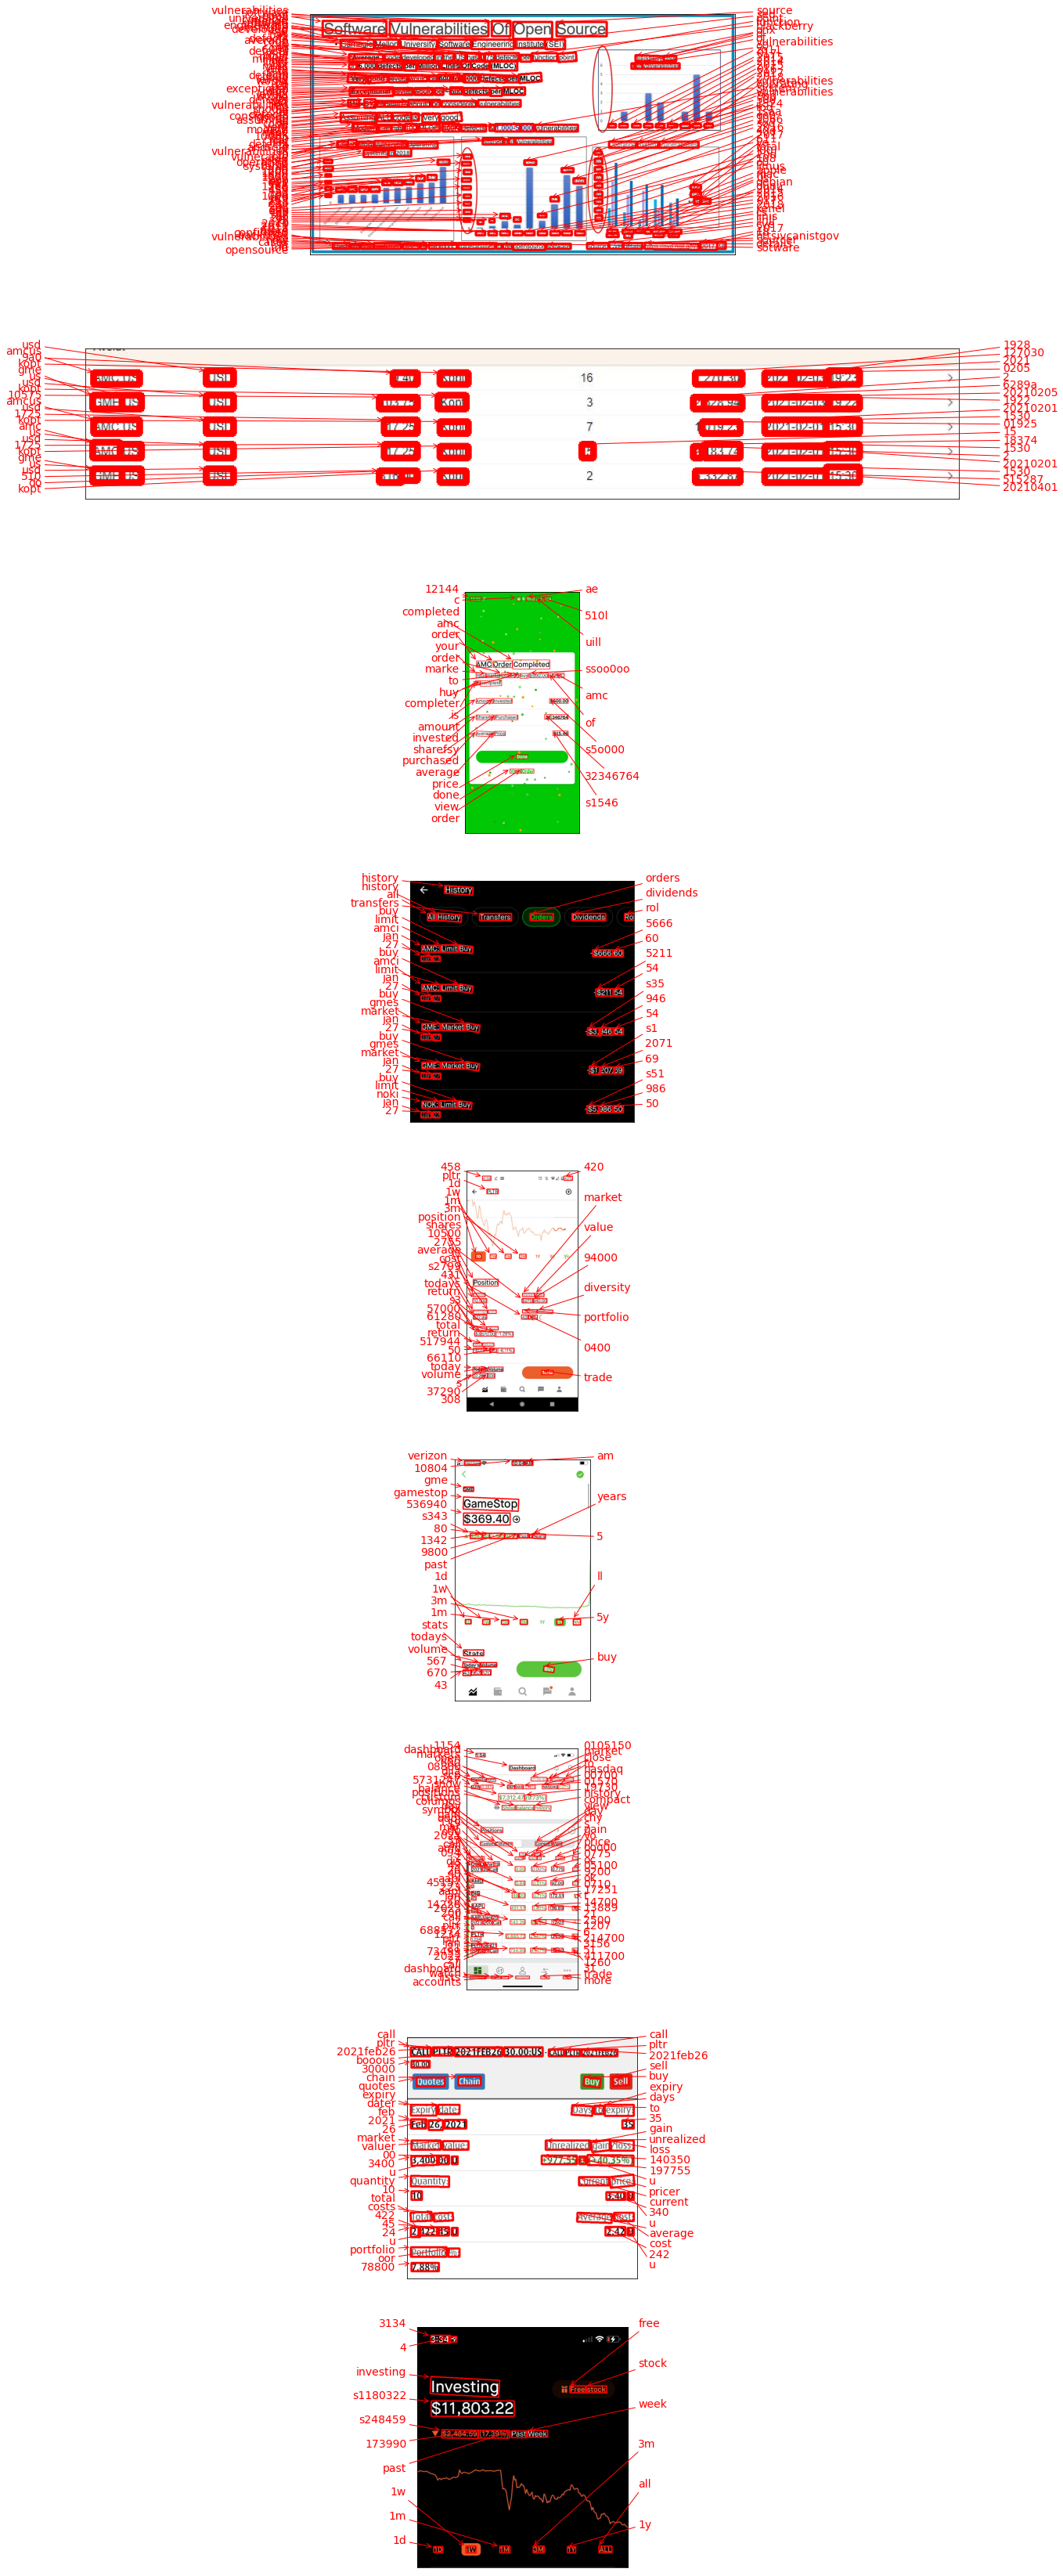

In [ ]:
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 60))
for ax, image, predictions in zip(axs, images, prediction_groups):
    keras_ocr.tools.drawAnnotations(image=image, predictions=predictions, ax=ax)

### Visual-text attributes

In [ ]:
df = pd.read_csv('with_image_deleted.csv', na_filter=False)

df_images = pd.read_csv('images_text.csv', na_filter=False)
df_images = df_images.set_index('filename')

def proces_image_text(row):
    file_path = row['file_path']

    image_text = df_images.loc[file_path].image_text

    processed_text = preproces_text(image_text)

    return processed_text

df['processed_image_text'] = df.loc[df['type'] == 'image'].apply(proces_image_text, axis='columns')

df.to_csv('with_processed_image_text.csv', index=False) 

df.loc[df['type'] == 'image'].head(5)

score  ...                               processed_image_text
1    1157  ...  estim pertorm cx vall margin gain x loss analy...
20     30  ...  walanl fl margn talcom 820279 estaa 919a7 fsa9...
22    370  ...  742 lte s483 amc 1d 1w 3m 1y 5y 1m posit share...
25    487  ...  gamestop akti aohgdx us36167w1074 wknb ise 08 ...
31     47  ...              melvin irwsb capit kaak sec robinhood

[5 rows x 94 columns]

In [ ]:
df = pd.read_csv('with_processed_image_text.csv', na_filter=False)

model = TfidfVectorizer(max_features=25, lowercase=True, analyzer='word', stop_words= 'english',ngram_range=(1,1))

tf_idf = model.fit_transform(df['processed_image_text'])

print(model.get_feature_names())

tf_idf_df = pd.DataFrame(tf_idf.toarray(), columns=model.get_feature_names())
tf_idf_df = tf_idf_df.add_prefix('image_text_')

df = pd.concat([df, tf_idf_df], axis='columns')

df.to_csv('with_image_text_tf_idf.csv', index=False) 

df.loc[df['type'] == 'image'].head(5)

['00', '1d', '2021', 'amc', 'buy', 'close', 'cost', 'day', 'gamestop', 'gme', 'invest', 'market', 'open', 'order', 'posit', 'price', 'return', 'sell', 'share', 'stock', 'today', 'total', 'trade', 'valu', 'volum']


score      id  ... image_text_valu  image_text_volum
1    1157  l87ci6  ...        0.549227               0.0
20     30  lcj6n5  ...        0.000000               0.0
22    370  l4qe5w  ...        0.203770               0.0
25    487  lbr3no  ...        0.000000               0.0
31     47  l72ol3  ...        0.000000               0.0

[5 rows x 119 columns]

In [ ]:
df = pd.read_csv('with_image_text_tf_idf.csv', na_filter=False)

df['image_text_chars_number'] = df['processed_image_text'].str.len()
df['image_text_words_number'] = df['processed_image_text'].str.split().str.len()
df['image_text_digits_number'] = df['processed_image_text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

df.to_csv('with_image_text_attributes.csv', index=False) 

df.loc[df['type'] == 'image'].head(5)


score      id  ... image_text_words_number  image_text_digits_number
1    1157  l87ci6  ...                      28                         6
20     30  lcj6n5  ...                      54                         1
22    370  l4qe5w  ...                      47                        10
25    487  lbr3no  ...                      45                        13
31     47  l72ol3  ...                       6                         0

[5 rows x 122 columns]

### Read objects

In [ ]:
def to_pandas(res):
        cols = 'confidence', 'name'
        a = [[[x[4], res.names[int(x[5])]] for x in x.tolist()] for x in getattr(res, 'xyxy')]
        dfs = [pd.DataFrame(x, columns=cols) for x in a]
        return dfs

batch_size = 25

model = torch.hub.load('ultralytics/yolov5', 'yolov5x')

# df = pd.DataFrame()
df = pd.read_csv('images_objects.csv', na_filter=False)

print(df.shape)

files = glob.glob(f"images/*.jpg")

files = [x for x in files if x not in df.filename.values]

batches = np.array_split(files, np.ceil(len(files)/batch_size))

for index, batch in enumerate(batches, start=1):
  start = time.time()
  images = list(batch)
  results = model(images)

  prediction_groups = to_pandas(results)

  for filename, group in zip(batch, prediction_groups): 
      words = group.name
      text = ' '.join(words)

      df = df.append({"filename": filename, "image_objects": text}, sort=False, ignore_index=True)
  
  elapsed = time.time() - start

  print(f"Processed: {index*batch_size} images, Batch processing time: {elapsed} s")

  df.to_csv('images_objects.csv', index=False) 

df.head(10)

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip


requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...

requirements: tqdm>=4.41.0 not found and is required by YOLOv5, attempting auto-update...

requirements: 2 packages updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



Fusing layers... 
Model Summary: 476 layers, 87730285 parameters, 0 gradients
Adding autoShape... 
YOLOv5 🚀 2021-5-2 torch 1.8.1+cu101 CPU



(12800, 2)
Processed: 25 images, Batch processing time: 110.47692346572876 s
Processed: 50 images, Batch processing time: 110.68231749534607 s
Processed: 75 images, Batch processing time: 105.26725029945374 s
Processed: 100 images, Batch processing time: 109.18729901313782 s
Processed: 125 images, Batch processing time: 108.04509043693542 s
Processed: 150 images, Batch processing time: 110.10369896888733 s
Processed: 175 images, Batch processing time: 106.33018684387207 s
Processed: 200 images, Batch processing time: 105.41022253036499 s
Processed: 225 images, Batch processing time: 103.8605785369873 s
Processed: 250 images, Batch processing time: 103.90945959091187 s
Processed: 275 images, Batch processing time: 104.64504146575928 s
Processed: 300 images, Batch processing time: 104.48961281776428 s
Processed: 325 images, Batch processing time: 100.76735854148865 s
Processed: 350 images, Batch processing time: 104.7985634803772 s
Processed: 375 images, Batch processing time: 103.468950

filename                                      image_objects
0  images/l94y5a.jpg                                                   
1  images/l9xbcd.jpg                                                   
2  images/l9x7yh.jpg  tie person person person person tie person tie...
3  images/l9wxme.jpg                                         person tie
4  images/l9x3sg.jpg                                                   
5  images/l9wkh5.jpg                                             laptop
6  images/l9w466.jpg                                                   
7  images/l9v17h.jpg         person person tie person tie person person
8  images/l9uf9l.jpg                                        sports ball
9  images/l9thkw.jpg

### Example of read objects

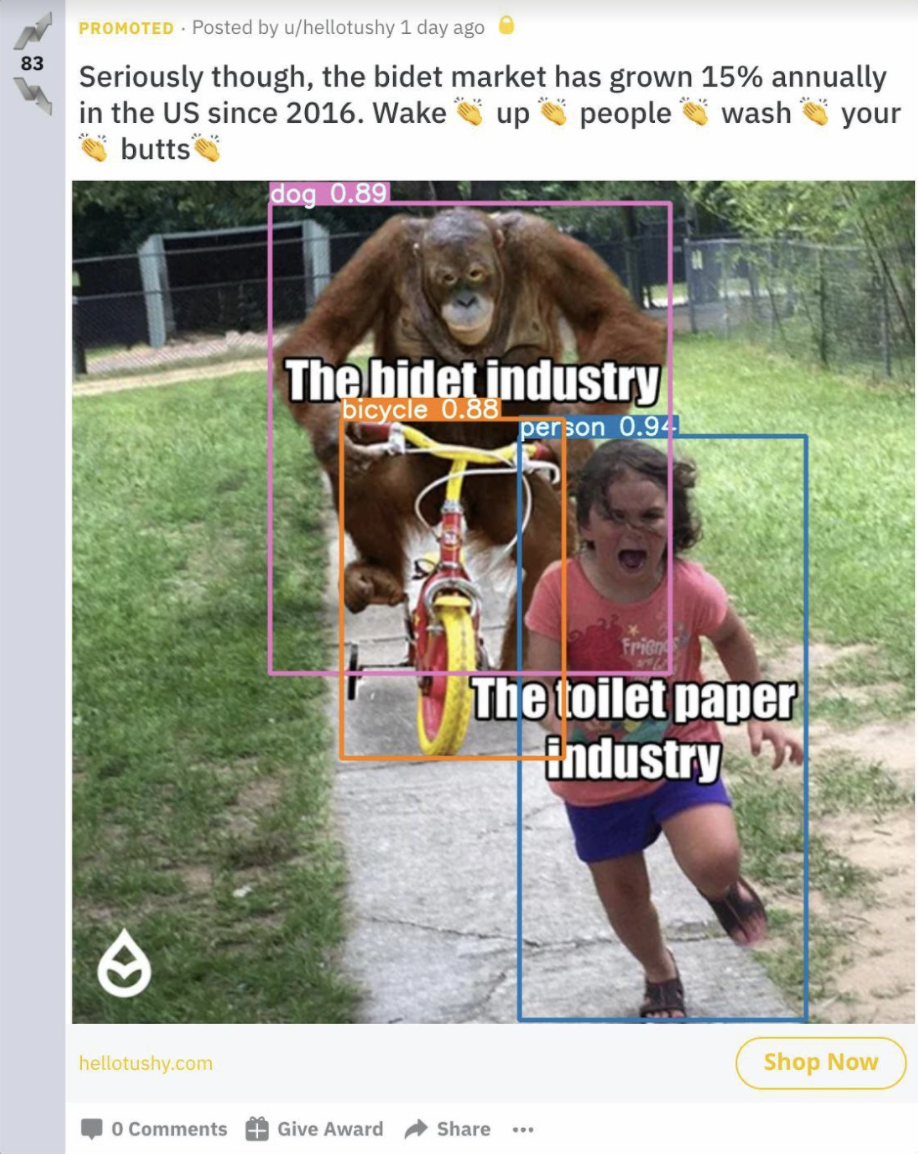

### Visual-objects attributes

In [ ]:
df = pd.read_csv('with_image_text_attributes.csv', na_filter=False)

df_images = pd.read_csv('images_objects.csv', na_filter=False)
df_images = df_images.set_index('filename')

def proces_image_objects(row):
    file_path = row['file_path']

    image_text = df_images.loc[file_path].image_objects

    processed_text = preproces_text(image_text)

    return processed_text

df['processed_image_objects'] = df.loc[df['type'] == 'image'].apply(proces_image_objects, axis='columns')

df.to_csv('with_processed_image_objects.csv', index=False) 

df.loc[df['type'] == 'image'].head(5)

score      id  ... image_text_digits_number      processed_image_objects
1    1157  l87ci6  ...                        6                             
20     30  lcj6n5  ...                        1                       laptop
22    370  l4qe5w  ...                       10                             
25    487  lbr3no  ...                       13                             
31     47  l72ol3  ...                        0  person person person person

[5 rows x 123 columns]

In [ ]:
df = pd.read_csv('with_processed_image_objects.csv', na_filter=False)

model = TfidfVectorizer(max_features=25, lowercase=True, analyzer='word', stop_words= 'english',ngram_range=(1,1))

tf_idf = model.fit_transform(df['processed_image_objects'])

print(model.get_feature_names())

tf_idf_df = pd.DataFrame(tf_idf.toarray(), columns=model.get_feature_names())
tf_idf_df = tf_idf_df.add_prefix('image_objects_')

df = pd.concat([df, tf_idf_df], axis='columns')

df.to_csv('with_image_objects_tf_idf.csv', index=False) 

df.loc[df['type'] == 'image'].head(5)

['airplan', 'ball', 'bird', 'book', 'bottl', 'car', 'cell', 'chair', 'clock', 'cup', 'frisbe', 'hors', 'keyboard', 'kite', 'laptop', 'light', 'person', 'phone', 'refriger', 'remot', 'snowboard', 'sport', 'tie', 'traffic', 'tv']


score      id  ... image_objects_traffic  image_objects_tv
1    1157  l87ci6  ...                   0.0               0.0
20     30  lcj6n5  ...                   0.0               0.0
22    370  l4qe5w  ...                   0.0               0.0
25    487  lbr3no  ...                   0.0               0.0
31     47  l72ol3  ...                   0.0               0.0

[5 rows x 148 columns]

In [ ]:
df = pd.read_csv('with_image_objects_tf_idf.csv', na_filter=False)

df['image_objects_number'] = df['processed_image_objects'].str.split().str.len()

df.to_csv('with_image_objects_attributes.csv', index=False) 

df.loc[df['type'] == 'image'].head(5)

score      id  ... image_objects_tv  image_objects_number
1    1157  l87ci6  ...              0.0                     0
20     30  lcj6n5  ...              0.0                     1
22    370  l4qe5w  ...              0.0                     0
25    487  lbr3no  ...              0.0                     0
31     47  l72ol3  ...              0.0                     4

[5 rows x 149 columns]

### Read colors

In [ ]:
def extract_colors_img(img, k_colors, verbose=False):
  image = cv2.imread(img,1)
  image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  # for plotting purposes
  cast = np.array(image, dtype=np.float64) / 255

  w, h, d = original_shape = tuple(cast.shape)
  assert d == 3
  image_array = np.reshape(cast, (w * h, d))

  # fit k-means
  t0 = time.time()
  image_array_sample = shuffle(image_array, random_state=0)[:int(w*h*0.01)]
  kmeans = KMeans(n_clusters=k_colors, random_state=0).fit(image_array_sample)
  if verbose:
    print("Fitting done in %0.3fs." % (time.time() - t0))

  # centers of colors
  t0 = time.time()
  labels = kmeans.predict(image_array)
  if verbose:
    print("Quantization done in %0.3fs." % (time.time() - t0))

  def recreate_image(codebook, labels, w, h):
      """Recreate the (compressed) image from the code book & labels"""
      d = codebook.shape[1]
      image = np.zeros((w, h, d))
      label_idx = 0
      for i in range(w):
          for j in range(h):
              image[i][j] = codebook[labels[label_idx]]
              label_idx += 1
      return image
  if verbose:
    plt.figure(1)
    plt.clf()
    plt.axis('off')
    plt.title(f"Color palette")
    plt.imshow(kmeans.cluster_centers_.reshape(1,k_colors,3))
    print(f"Counts: {np.bincount(kmeans.labels_[kmeans.labels_>=0])}")
  indices = np.flip(np.bincount(kmeans.labels_[kmeans.labels_>=0]).argsort())
  colors = kmeans.cluster_centers_[indices]

  if verbose:
    # Display results, alongside original image
    plt.figure(2)
    plt.clf()
    plt.axis('off')
    plt.title('Original image')
    plt.imshow(cast)

    plt.figure(3)
    plt.clf()
    plt.axis('off')
    plt.title(f"Quantized image ({k_colors}) colors, K-Means)")
    plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

    plt.figure(4)
    plt.clf()
    plt.axis('off')
    plt.title(f"Sorted color palette")
    plt.imshow(colors.reshape(1,k_colors,3))

  return colors

In [ ]:
batch_size = 100

# df = pd.DataFrame()
df = pd.read_csv('images_colors.csv', na_filter=False)

print(df.shape)

files = glob.glob(f"images/*.jpg")

files = [x for x in files if x not in df.filename.values]

batches = np.array_split(files, np.ceil(len(files)/batch_size))

for index, batch in enumerate(batches, start=1):
  start = time.time()
  images = list(batch)

  for filename in batch: 
      colors = extract_colors_img(filename, 5, False).tolist()
      df = df.append({"filename": filename, "image_colors": colors}, sort=False, ignore_index=True)
  
  elapsed = time.time() - start

  print(f"Processed: {index*batch_size} images, Batch processing time: {elapsed} s")

  df.to_csv('images_colors.csv', index=False) 

df.head(10)

Processed: 100 images, Batch processing time: 137.760333776474 s
Processed: 200 images, Batch processing time: 152.04640674591064 s
Processed: 300 images, Batch processing time: 152.55625700950623 s
Processed: 400 images, Batch processing time: 168.82391571998596 s
Processed: 500 images, Batch processing time: 147.65222072601318 s
Processed: 600 images, Batch processing time: 115.81094551086426 s
Processed: 700 images, Batch processing time: 86.30250597000122 s
Processed: 800 images, Batch processing time: 83.47257924079895 s
Processed: 900 images, Batch processing time: 101.2658760547638 s
Processed: 1000 images, Batch processing time: 103.75200486183167 s
Processed: 1100 images, Batch processing time: 74.63921022415161 s
Processed: 1200 images, Batch processing time: 80.27824664115906 s
Processed: 1300 images, Batch processing time: 84.71024203300476 s
Processed: 1400 images, Batch processing time: 83.00712084770203 s


(2560, 1440, 3)
Fitting done in 0.453s.
Quantization done in 0.436s.
Counts: [1436 1042  240  571  397]


array([[0.99336392, 0.99406303, 0.99429789],
       [0.12084842, 0.12461538, 0.15296757],
       [0.01949109, 0.02508842, 0.04322654],
       [0.20295838, 0.27411666, 0.3998624 ],
       [0.52576797, 0.44550654, 0.4873366 ]])

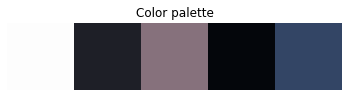

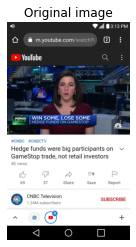

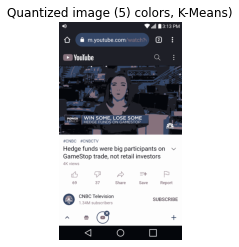

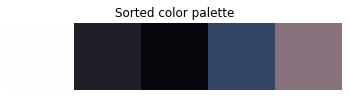

In [ ]:
img = "images/ldk4db.jpg"
extract_colors_img(img, 5, True)

In [ ]:
df = pd.read_csv('with_image_objects_attributes.csv', na_filter=False)

df_images_colors = pd.read_csv('images_colors.csv', na_filter=False)
df_images_colors = df_images_colors.set_index('filename')
df_images_colors.image_colors = df_images_colors.image_colors.apply(json.loads)

colors_names = [f'color_{x}' for x in range(1,6)]

def proces_image_colors(row):
    file_path = row['file_path']

    image_colors = df_images_colors.loc[file_path].image_colors

    colors = {}

    for index, image_color in enumerate(image_colors):
      img = np.array([[image_color]], np.float32)
      hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
      [[H]], [[S]], [[V]] = cv2.split(hsv)
      colors[f'{colors_names[index]}_h'] = H
      colors[f'{colors_names[index]}_s'] = S
      colors[f'{colors_names[index]}_v'] = V

    return colors

applied_df = df.loc[df['type'] == 'image'].apply(proces_image_colors, axis='columns', result_type='expand')

df = pd.concat([df, applied_df], axis='columns')

df.to_csv('with_most_dominant_colors.csv', index=False) 

df.loc[df['type'] == 'image'].head(2)

score      id  ... color_5_s  color_5_v
4     71  l6ufgy  ...  0.023079   0.330861
5    405  l6uf7d  ...  0.026792   0.773669

[2 rows x 163 columns]